# ADE20k-outdoors (5k) and Coco-stuff (5k)

Pre-processing is very similar.

**Run in Colab**

**Add a shortcut of the folder to Drive:**

https://drive.google.com/drive/folders/1UJoz71WnE8Erpdi1apK_zOHBicnMW65F?usp=sharing

If you want to run locally, download data first (ade20k and coco).

## 1. ADE20k-outdoors Dataset - the subset of ADE20k

Dataset is taken from https://www.kaggle.com/residentmario/ade20k-outdoors.

* Size: 5000 images (200 MB).

* Images directory: *ade20k-outdoors/images/training/*

* Masks (labels/annotations) directory: *ade20k-outdoors/annotations/training/*

* Min h: 140, min w: 137, max h: 1460, max w: 1270

#### What is done

* Division by train (4000), val (500), test (500)

* Classes - ADEDatasetTrain, ADEDatasetVal, ADEDatasetTest

* Resizing of images and masks to (256, 256, 3) because they have different sizes

* Normalizing of images (/255)

* Plot examples

#### Open questions

* Mask shape? Now it is (3, 256, 256). Do we need 3 channels?

* Any more preprocessing? 

* Data augmentation?

In [5]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# `AUX_DATA_ROOT` is where folders with data are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/DL_project_data")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgotten to 'Add a shortcut to Drive'?"
    
    # import sys
    # sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import numpy as np
import cv2

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset

In [0]:
ade_images_dir = str(AUX_DATA_ROOT) + '/ade20k-outdoors/images/training/'
ade_masks_dir = str(AUX_DATA_ROOT) + '/ade20k-outdoors/annotations/training/'

ade_images_files = os.listdir(ade_images_dir)
ade_images_files.sort()
    
ade_train_images_files = ade_images_files[:4000]
ade_val_images_files = ade_images_files[4000:4500]
ade_test_images_files = ade_images_files[4500:5000]

In [0]:
# max_h = 0
# max_w = 0
# min_h = 10000
# min_w = 10000

# for file in ade_images_files:
#     im = cv2.imread(ade_images_dir + file)
#     w, h, _ = im.shape
#     if w < min_w:
#         min_w = w
#     if h < min_h:
#         min_h = h
#     if w > max_w:
#         max_w = w
#     if h > max_h:
#         max_h = h
        
# print('Min h: %d, min w: %d, max h: %d, max w: %d' % (min_h, min_w, max_h, max_w))

Min h: 140, min w: 137, max h: 1460, max w: 1270


In [0]:
class ADEDatasetTrain(Dataset):
    def __init__(self, images_dir, masks_dir, train_images_files):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        
        self.new_h = 256
        self.new_w = 256

        self.examples = []

        for file_name in train_images_files:
            image_id = file_name.split('ADE_train_')[1].split('.jpg')[0]
            image_path = self.images_dir + file_name
            mask_path = self.masks_dir + 'ADE_train_' + image_id + ".png"

            example = {}
            example["image_id"] = image_id
            example["image_path"] = image_path
            example["mask_path"] = mask_path            
            self.examples.append(example)

        self.num_examples = len(self.examples)
        
    def __getitem__(self, index):
        example = self.examples[index]
    

        image_path = example["image_path"]
        image = cv2.imread(image_path) 

        mask_path = example["mask_path"]        
        mask = cv2.imread(mask_path)
        
        image = cv2.resize(image, (self.new_w, self.new_h),
                               interpolation=cv2.INTER_NEAREST) # shape = (256, 256, 3)
        mask = cv2.resize(mask, (self.new_w, self.new_h),
                               interpolation=cv2.INTER_NEAREST) # shape = (256, 256, 3)

        # normalize
        image = image / 255.0
        
        # convert numpy -> torch
        image = np.transpose(image, (2, 0, 1)) # shape = (3, 256, 256)
        mask = np.transpose(mask, (2, 0, 1)) # shape = (3, 256, 256)
        image = image.astype(np.float32)

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return (image, mask)

    def __len__(self):
        return self.num_examples
    
    
    
class ADEDatasetVal(Dataset):
    def __init__(self, images_dir, masks_dir, val_images_files):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        
        self.new_h = 256
        self.new_w = 256

        self.examples = []

        for file_name in val_images_files:
            image_id = file_name.split('ADE_train_')[1].split('.jpg')[0]
            image_path = self.images_dir + file_name
            mask_path = self.masks_dir + 'ADE_train_' + image_id + ".png"

            example = {}
            example["image_id"] = image_id
            example["image_path"] = image_path
            example["mask_path"] = mask_path            
            self.examples.append(example)

        self.num_examples = len(self.examples)
        
    def __getitem__(self, index):
        example = self.examples[index]
    

        image_path = example["image_path"]
        image = cv2.imread(image_path) 

        mask_path = example["mask_path"]        
        mask = cv2.imread(mask_path)
        
        image = cv2.resize(image, (self.new_w, self.new_h),
                               interpolation=cv2.INTER_NEAREST) # shape = (256, 256, 3)
        mask = cv2.resize(mask, (self.new_w, self.new_h),
                               interpolation=cv2.INTER_NEAREST) # shape = (256, 256, 3)
        
        # normalize
        image = image / 255.0
        
        # convert numpy -> torch
        image = np.transpose(image, (2, 0, 1)) # shape = (3, 256, 256)
        mask = np.transpose(mask, (2, 0, 1)) # shape = (3, 256, 256)
        image = image.astype(np.float32)

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return (image, mask)

    def __len__(self):
        return self.num_examples
    

    
class ADEDatasetTest(Dataset):
    def __init__(self, images_dir, masks_dir, test_images_files):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        
        self.new_h = 256
        self.new_w = 256

        self.examples = []

        for file_name in test_images_files:
            image_id = file_name.split('ADE_train_')[1].split('.jpg')[0]
            image_path = self.images_dir + file_name
            mask_path = self.masks_dir + 'ADE_train_' + image_id + ".png"

            example = {}
            example["image_id"] = image_id
            example["image_path"] = image_path
            example["mask_path"] = mask_path            
            self.examples.append(example)

        self.num_examples = len(self.examples)
        
    def __getitem__(self, index):
        example = self.examples[index]
    

        image_path = example["image_path"]
        image = cv2.imread(image_path) 

        mask_path = example["mask_path"]        
        mask = cv2.imread(mask_path)
        
        image = cv2.resize(image, (self.new_w, self.new_h),
                               interpolation=cv2.INTER_NEAREST) # shape = (256, 256, 3)
        mask = cv2.resize(mask, (self.new_w, self.new_h),
                               interpolation=cv2.INTER_NEAREST) # shape = (256, 256, 3)
        
        # normalize
        image = image / 255.0
        
        # convert numpy -> torch
        image = np.transpose(image, (2, 0, 1)) # shape = (3, 256, 256)
        mask = np.transpose(mask, (2, 0, 1)) # shape = (3, 256, 256)
        image = image.astype(np.float32)

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return (image, mask)

    def __len__(self):
        return self.num_examples

In [0]:
ade_train_dataset = ADEDatasetTrain(ade_images_dir, ade_masks_dir, ade_train_images_files)
ade_val_dataset = ADEDatasetVal(ade_images_dir, ade_masks_dir, ade_val_images_files)
ade_test_dataset = ADEDatasetTest(ade_images_dir, ade_masks_dir, ade_test_images_files)

In [0]:
def plot_example(image, mask):
    fig=plt.figure(figsize=(8, 8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(image)
    fig.add_subplot(1, 2, 2)
    plt.imshow(mask)
    plt.show()

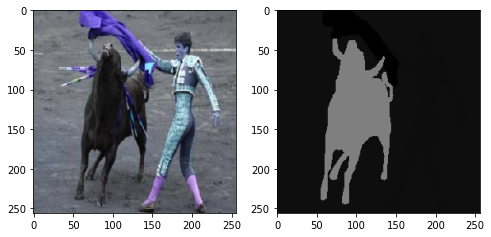

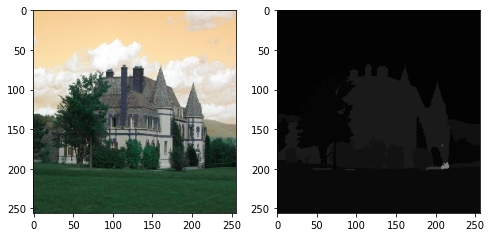

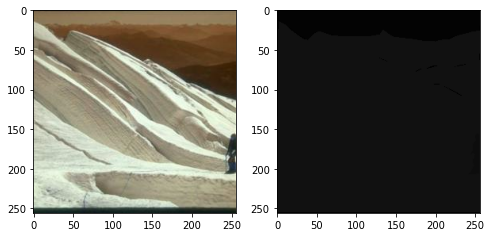

In [29]:
# plot train examples
for ex_id in [5, 10, 2550]:
    ex = ade_train_dataset[ex_id]
    plot_example(ex[0].permute(1, 2, 0), ex[1].permute(1, 2, 0))

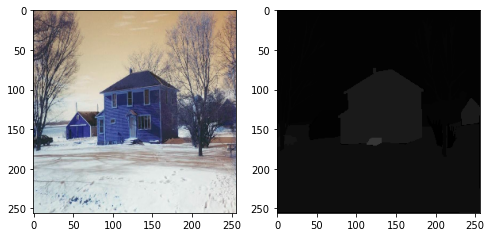

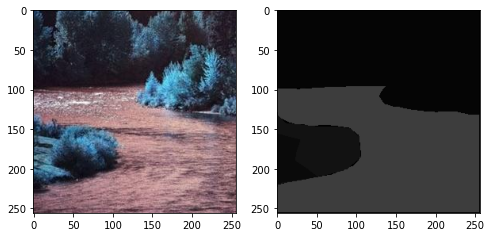

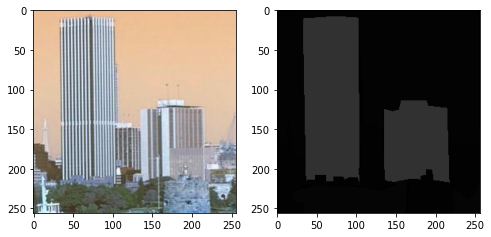

In [30]:
# plot val examples
for ex_id in [25, 55, 355]:
    ex = ade_val_dataset[ex_id]
    plot_example(ex[0].permute(1, 2, 0), ex[1].permute(1, 2, 0))

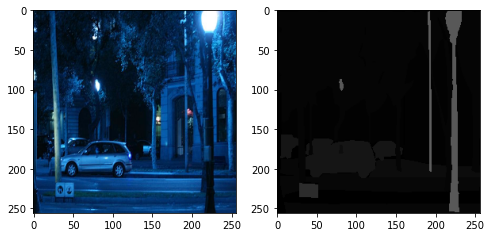

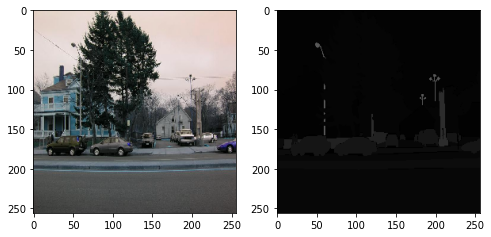

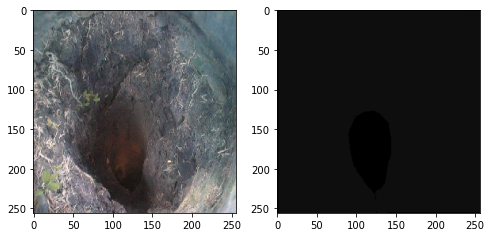

In [31]:
# plot test examples
for ex_id in [25, 55, 300]:
    ex = ade_test_dataset[ex_id]
    plot_example(ex[0].permute(1, 2, 0), ex[1].permute(1, 2, 0))

## 2. Coco-stuff (only validation part)

Dataset is taken from https://github.com/nightrome/cocostuff#downloads: 

* val2017.zip (contains images)
* stuffthingmaps_trainval2017.zip (contains masks)

Data description:

* Size: 5000 images (800 Mb).

* Images directory: *coco-stuff/val_images2017/*

* Masks (labels/annotations) directory: *coco-stuff/val_labels2017/*

* Min h: 200, min w: 145, max h: 640, max w: 640

#### What is done

* Division by train (4000), val (500), test (500)

* Classes - CocoDatasetTrain, CocoDatasetVal, CocoDatasetTest

* Resizing of images and masks to (256, 256, 3) because they have different sizes

* Normalizing of images (/255)

* Plot examples

#### Open questions

* Mask shape? Now it is (3, 256, 256). Do we need 3 channels?

* Any more preprocessing? 

* Data augmentation?

In [0]:
coco_images_dir = str(AUX_DATA_ROOT) + '/coco-stuff/val_images2017/'
coco_masks_dir = str(AUX_DATA_ROOT) + '/coco-stuff/val_labels2017/'

(503, 640, 3)
(503, 640, 3)


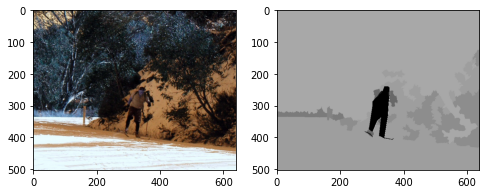

In [17]:
# plot example
im = cv2.imread(coco_images_dir + '000000096825.jpg')
mask = cv2.imread(coco_masks_dir + '000000096825.png')
print(im.shape)
print(mask.shape)
plot_example(im, mask)

In [0]:
coco_images_files = os.listdir(coco_images_dir)
coco_images_files.sort()

coco_train_images_files = coco_images_files[:4000]
coco_val_images_files = coco_images_files[4000:4500]
coco_test_images_files = coco_images_files[4500:5000]

In [0]:
# max_h = 0
# max_w = 0
# min_h = 10000
# min_w = 10000

# for file in coco_images_files:
#     im = cv2.imread(coco_images_dir + file)
#     w, h, _ = im.shape
#     if w < min_w:
#         min_w = w
#     if h < min_h:
#         min_h = h
#     if w > max_w:
#         max_w = w
#     if h > max_h:
#         max_h = h
        
# print('Min h: %d, min w: %d, max h: %d, max w: %d' % (min_h, min_w, max_h, max_w))

Min h: 200, min w: 145, max h: 640, max w: 640


In [0]:
class CocoDatasetTrain(Dataset):
    def __init__(self, images_dir, masks_dir, train_images_files):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        
        self.new_h = 256
        self.new_w = 256

        self.examples = []

        for file_name in train_images_files:
            image_id = file_name.split('.jpg')[0]
            image_path = self.images_dir + file_name
            mask_path = self.masks_dir + image_id + ".png"

            example = {}
            example["image_id"] = image_id
            example["image_path"] = image_path
            example["mask_path"] = mask_path            
            self.examples.append(example)

        self.num_examples = len(self.examples)
        
    def __getitem__(self, index):
        example = self.examples[index]
    

        image_path = example["image_path"]
        image = cv2.imread(image_path) 

        mask_path = example["mask_path"]        
        mask = cv2.imread(mask_path)
        
        image = cv2.resize(image, (self.new_w, self.new_h),
                               interpolation=cv2.INTER_NEAREST) # shape = (256, 256, 3)
        mask = cv2.resize(mask, (self.new_w, self.new_h),
                               interpolation=cv2.INTER_NEAREST) # shape = (256, 256, 3)

        # normalize
        image = image / 255.0
        
        # convert numpy -> torch
        image = np.transpose(image, (2, 0, 1)) # shape = (3, 256, 256)
        mask = np.transpose(mask, (2, 0, 1)) # shape = (3, 256, 256)
        image = image.astype(np.float32)

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return (image, mask)

    def __len__(self):
        return self.num_examples
    
    
    
class CocoDatasetVal(Dataset):
    def __init__(self, images_dir, masks_dir, val_images_files):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        
        self.new_h = 256
        self.new_w = 256

        self.examples = []

        for file_name in val_images_files:
            image_id = file_name.split('.jpg')[0]
            image_path = self.images_dir + file_name
            mask_path = self.masks_dir + image_id + ".png"

            example = {}
            example["image_id"] = image_id
            example["image_path"] = image_path
            example["mask_path"] = mask_path            
            self.examples.append(example)

        self.num_examples = len(self.examples)
        
    def __getitem__(self, index):
        example = self.examples[index]
    

        image_path = example["image_path"]
        image = cv2.imread(image_path) 

        mask_path = example["mask_path"]        
        mask = cv2.imread(mask_path)
        
        image = cv2.resize(image, (self.new_w, self.new_h),
                               interpolation=cv2.INTER_NEAREST) # shape = (256, 256, 3)
        mask = cv2.resize(mask, (self.new_w, self.new_h),
                               interpolation=cv2.INTER_NEAREST) # shape = (256, 256, 3)
        
        # normalize
        image = image / 255.0
        
        # convert numpy -> torch
        image = np.transpose(image, (2, 0, 1)) # shape = (3, 256, 256)
        mask = np.transpose(mask, (2, 0, 1)) # shape = (3, 256, 256)
        image = image.astype(np.float32)

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return (image, mask)

    def __len__(self):
        return self.num_examples
    

    
class CocoDatasetTest(Dataset):
    def __init__(self, images_dir, masks_dir, test_images_files):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        
        self.new_h = 256
        self.new_w = 256

        self.examples = []

        for file_name in test_images_files:
            image_id = file_name.split('.jpg')[0]
            image_path = self.images_dir + file_name
            mask_path = self.masks_dir + image_id + ".png"

            example = {}
            example["image_id"] = image_id
            example["image_path"] = image_path
            example["mask_path"] = mask_path            
            self.examples.append(example)

        self.num_examples = len(self.examples)
        
    def __getitem__(self, index):
        example = self.examples[index]
    

        image_path = example["image_path"]
        image = cv2.imread(image_path) 

        mask_path = example["mask_path"]        
        mask = cv2.imread(mask_path)
        
        image = cv2.resize(image, (self.new_w, self.new_h),
                               interpolation=cv2.INTER_NEAREST) # shape = (256, 256, 3)
        mask = cv2.resize(mask, (self.new_w, self.new_h),
                               interpolation=cv2.INTER_NEAREST) # shape = (256, 256, 3)
        
        # normalize
        image = image / 255.0
        
        # convert numpy -> torch
        image = np.transpose(image, (2, 0, 1)) # shape = (3, 256, 256)
        mask = np.transpose(mask, (2, 0, 1)) # shape = (3, 256, 256)
        image = image.astype(np.float32)

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return (image, mask)

    def __len__(self):
        return self.num_examples

In [0]:
coco_train_dataset = CocoDatasetTrain(coco_images_dir, coco_masks_dir, coco_train_images_files)
coco_val_dataset = CocoDatasetVal(coco_images_dir, coco_masks_dir, coco_val_images_files)
coco_test_dataset = CocoDatasetTest(coco_images_dir, coco_masks_dir, coco_test_images_files)

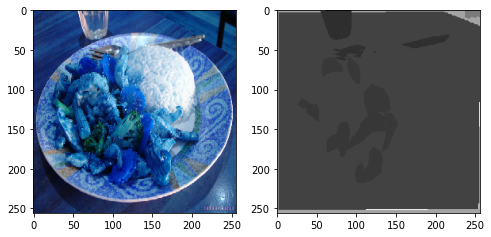

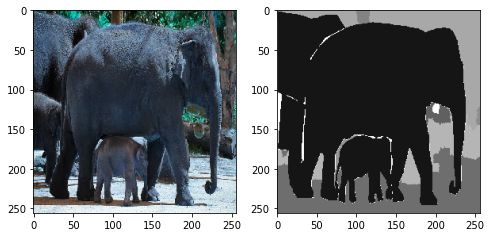

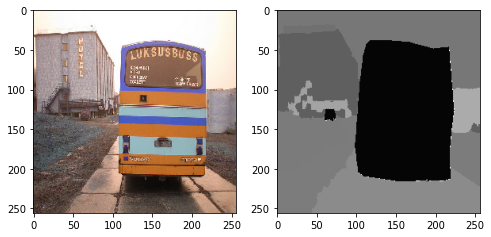

In [22]:
# plot train examples
for ex_id in [40, 500, 3000]:
    ex = coco_train_dataset[ex_id]
    plot_example(ex[0].permute(1, 2, 0), ex[1].permute(1, 2, 0))

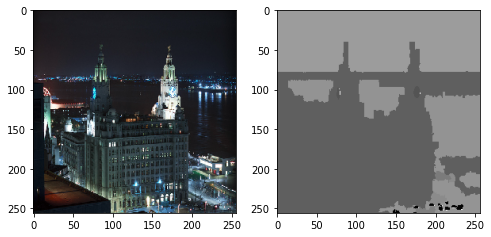

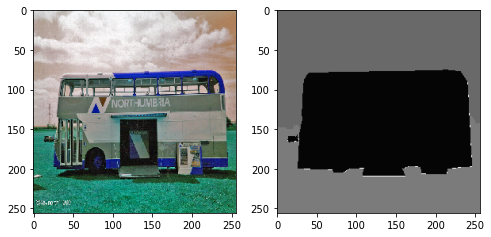

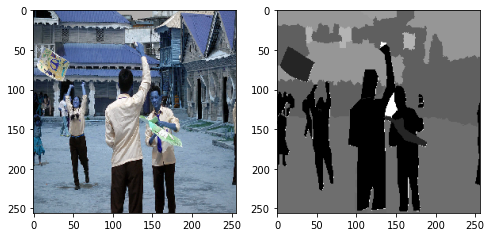

In [23]:
# plot val examples
for ex_id in [40, 50, 60]:
    ex = coco_val_dataset[ex_id]
    plot_example(ex[0].permute(1, 2, 0), ex[1].permute(1, 2, 0))

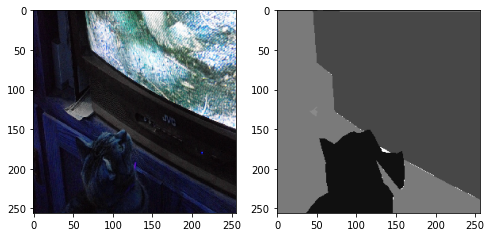

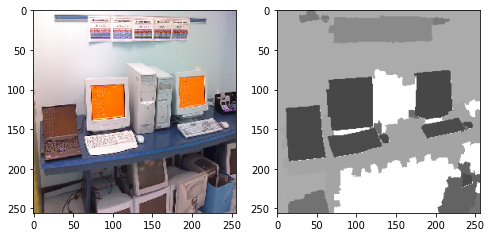

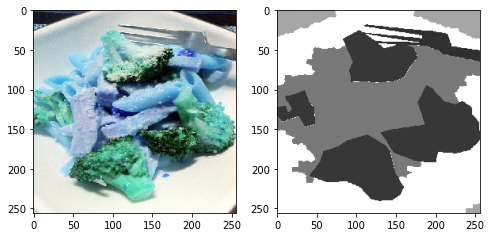

In [24]:
# plot test examples
for ex_id in [100, 200, 300]:
    ex = coco_test_dataset[ex_id]
    plot_example(ex[0].permute(1, 2, 0), ex[1].permute(1, 2, 0))